In [18]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple, Counter;
import numpy as np;
np.random.seed(1234)

scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)
import keras

scriptsDir = os.environ.get("DEEPLIFT_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable DEEPLIFT_DIR");
sys.path.insert(0,scriptsDir)

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
#import deepLIFT stuff
import deepLIFTutils
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/kerasBasedBackprop");
from deepLIFTonGPU import ScoreTypes, Activations_enum, OutLayerInfo, getScoreFunc

In [3]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
import vgg16_keras 
reload(vgg16_keras)
from vgg16_keras import *
import h5py
reload(deepLIFTutils)
#/srv/scratch/annashch/cs231n_project/vgg16_weights_dropout_regularization_augmenteddataTintContrast.stupidsgd.hdf5
model=VGG_16('vgg16_weights_dropout_regularization_augmenteddataTintContrast.stupidsgd.hdf5')

In [4]:
model.layers

In [6]:
import h5py
data=h5py.File('imagenet.validation.first50.hdf5','r')
validData=np.asarray(data['X_valid'])
Y_valid=np.asarray(data['Y_valid'])
data=validData 

In [20]:
#get the outputs of the net on the validation set
reload(deepLIFTutils)
print(np.shape(data))
import theano
import deeplift_util

output_func = theano.function([model.layers[0].input], model.layers[-1].get_output(train=False), allow_input_downcast=True)
outputs = deeplift_util.run_function_in_batches(output_func, input_data_list=[data])
outputs=np.array(outputs)

(50, 3, 64, 64)
Done 0


In [21]:
idx = 18
softmax_class = np.argmax(Y_valid[idx])
print("class:",softmax_class)

class: 117


In [24]:
#compile the gradient function
grad_var = theano.tensor.grad(
            theano.tensor.sum(model.layers[-2].get_output(train=False)[:,softmax_class]),
            model.layers[0].input)
grad_func = theano.function([model.layers[0].input], grad_var, allow_input_downcast=True)

In [25]:
#compute the gradients
gradients = deeplift_util.run_function_in_batches(grad_func, input_data_list=[data])

Done 0


In [28]:
def rescale_func(values):
    values = 255.0*(values - np.min(values))/(np.max(values)-np.min(values))
    return values

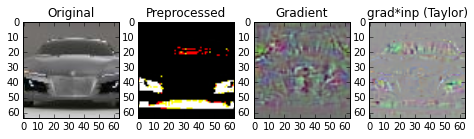

In [43]:
import skimage 
from skimage.io import imread
import matplotlib.pyplot as plt
img_original=imread('val_'+str(idx)+'.JPEG').astype(np.uint8)
plt.figure(figsize=(10, 2), facecolor='w')
plt.suptitle("")
plt.subplot(1, 5, 1)
plt.title('Original')
plt.imshow(img_original)
plt.subplot(1,5,2)
plt.title('Preprocessed')
plt.imshow(data[idx].transpose(1,2,0).astype(np.uint8))
plt.subplot(1,5,3)
plt.title('Gradient')
plt.imshow(rescale_func(gradients[idx]).transpose(1,2,0).astype(np.uint8))
plt.subplot(1,5,4)
plt.title('grad*inp (Taylor)')
plt.imshow(rescale_func(gradients[idx]*data[idx]).transpose(1,2,0).astype(np.uint8))
